In [7]:
from os.path import join
import json
import numpy as np
from scipy import signal
import librosa 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
def read_dataset(input_path, num_patients):
    data = []
    for i in range(num_patients):
        with open(join(input_path, str(i+1)+ '.json'), 'r') as f:
            data.append(json.load(f))
    return data

def moving_window(signal, window_size):
    shape = signal.shape[:-1] + (signal.shape[-1] - window_size + 1, window_size)
    strides = signal.strides + (signal.strides[-1],)
    return np.lib.stride_tricks.as_strided(signal, shape=shape, strides=strides)

def data_cleaning(data, max_diff=50, window_size=10):
    data_FSR = -np.array(data['data_FSR'])
    data_FSR_clear = np.array(data_FSR, dtype=np.float)
    data_FSR_outliers = np.abs(data_FSR[1:] - data_FSR[:-1]) > max_diff
    data_FSR_outliers = np.append(data_FSR_outliers, False)
    data_FSR_clear[data_FSR_outliers] = np.nan
    data_FSR_roll_mean = np.nanmean(moving_window(data_FSR_clear, window_size), axis=-1)
    data_FSR_clear[np.isnan(data_FSR_clear)] = \
    data_FSR_roll_mean[np.isnan(data_FSR_clear)[:1-window_size]]
    data_FSR_smooth = signal.savgol_filter(data_FSR_clear, 51, 0)
    return data_FSR_smooth

def find_mins(signal, num_mins, window_size):
    found_mins = []
    signal_max = signal.max()
    
    hwindow = window_size // 2
    
    signal = np.array(signal)

    for i in range(num_mins):
        found_min = np.argmin(signal)
        found_mins.append(found_min)
        signal[found_min-hwindow:found_min+hwindow] = signal_max
                
    return sorted(found_mins)

def window_finder(data, cleaned_data, diff_n=1000, roll_window = 21, min_window = 15000):
    data_FSR_diff = cleaned_data[diff_n:] - cleaned_data[:-diff_n]
    data_FSR_diff_roll = moving_window(data_FSR_diff, roll_window).mean(axis=-1)
    num_mins = len(data['data_BP'])
    data_FSR_mins = find_mins(data_FSR_diff_roll, num_mins, min_window)
    data_FSR_max, data_FSR_min = cleaned_data.max(), cleaned_data.min()
    points = [0]
    for m in data_FSR_mins:
        points.append(m + diff_n/2)
        
    windows = []
    for i in range(len(points)-1):
        windows.append(cleaned_data[int(points[i]):int(points[i+1])])
        
    BPs = data['data_BP']
    
    final_data = {}
    for i in range(len(BPs)):
        final_data[i] = {'window' : windows[i], 'SBP' : BPs[i]['SBP'], 'DBP' : BPs[i]['DBP']}
    return data_FSR_max, data_FSR_min, points, final_data
    
def data_STFT(data, fs):
    for ind,person in enumerate(data):
        for d in person:
            if len(data[ind][d]['window']) != 0:
                 t, y, data[ind][d]['stft'] = signal.stft(data[ind][d]['window'], fs, nperseg=1000)
                #data[ind][d]['stft'] = librosa.amplitude_to_db(np.abs(librosa.stft(data[ind][d]['window'], n_fft)), ref=np.max)

In [3]:
def preparing_dataset(add):
    
    # Read the dataset
    input_path =  add
    n_patients = 26

    data = read_dataset(input_path, n_patients)
    
    # Clean the data set
    cleaned_data = []

    for i in range(len(data)):
        cleaned_data.append(data_cleaning(data[i]))
        
    # Creating Dictionary of data
    data_FSR_max = []
    data_FSR_min = []
    points = []
    final_data = []
    for i in range(len(data)):
        data_FSR_max_i, data_FSR_min_i, points_i, final_data_i = window_finder(data[i],cleaned_data[i])

        data_FSR_max.append(data_FSR_max_i)
        data_FSR_min.append(data_FSR_min_i)
        points.append(points_i)
        final_data.append(final_data_i)
        
    
    max_wind = 0    
    for ind,person in enumerate(final_data):
        for d in person:
            if max_wind < len(final_data[ind][d]['window']):
                max_wind = len(final_data[ind][d]['window'])
                
    for ind,person in enumerate(final_data):
        for d in person:
            final_data[ind][d]['window'] = np.pad(final_data[ind][d]['window'], (0,max_wind - len(final_data[ind][d]['window'])), 'constant')
            
    # Applying STFT on the signal
    fs = 10e3
    data_STFT(final_data, fs=fs)
    
    return final_data

Prepare the dataset

In [4]:
add = join('..', 'MileStone', 'Data', 'Cuff-less Non-invasive Blood Pressure Estimation Data Set')

final_data = preparing_dataset(add)

Create CNN data set

In [5]:
def CNN_dataset_maker(data):
    X = []
    y = []
    for ind,person in enumerate(data):
        for d in person:
            X.append(data[ind][d]['stft'])
            y.append([data[ind][d]['SBP'], data[ind][d]['DBP']])
    X = np.array(X)
    y = np.array(y)
    
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    
    return train_test_split(X, y, test_size=0.15)

In [13]:
xtrain, xtest, ytrain, ytest = CNN_dataset_maker(final_data)
xtrain.shape

(129, 501, 244, 1)

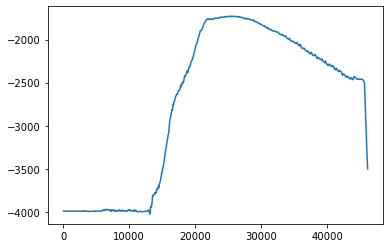

In [35]:
plt.plot(final_data[1][0]['window'][0:46127])

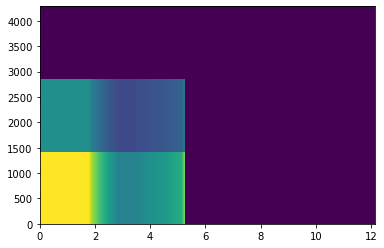

In [71]:
f, t, Zxx = signal.stft(final_data[5][0]['window'], fs=10e3, nperseg=7)
plt.pcolormesh(t, f, np.abs(Zxx))

Create CNN model

In [95]:
def CNN_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(501,244,1)))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='relu'))
    model.compile(loss="mae", optimizer="sgd")
    model.summary()
    
    return model

In [99]:
model = CNN_model()
model.fit(xtrain, ytrain, batch_size=12,epochs=200, verbose=0)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 499, 242, 64)      640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 249, 121, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 247, 119, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 123, 59, 64)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 121, 57, 64)       36928     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 119, 55, 64)       36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 117, 53, 64)      

KeyboardInterrupt: 

In [ ]:
ypred = model.predict(xtest)
print(model.evaluate(xtrain, ytrain))
print("MAE: %.4f" % mean_absolute_error(ytest, ypred))

In [ ]:
x_ax = range(len(ypred))
plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()